In [187]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

#set datadir based on cwd
cwd = os.getcwd()
#OSX
datadir = cwd + '/data/'
raw = pd.read_csv(datadir+'raw.csv')

#Windows
#datadir = cwd + '\\data\\'
#raw = pd.read_csv(datadir+'raw_data.csv')


<h3>Part 1: Data Cleaning and Validation<h3/>

In [188]:
df = raw.drop(['defendantid','NewArrests36','NewFelArrests36', 'NewMisdArrests36', 'NewViolArrests36','NewArrest36', 'NewFelArrest36', 'NewMisdArrest36', 'NewViolArrest36'],axis = 1)

#created binary target variable
#we are going to predict if the preson will commit a crime or not in the future 36 month
df = df.rename(columns={'NewArrest36Type':'NewArrest36'})
#classified target variable from multiclass to binary
df['NewArrest36'] = df['NewArrest36'].apply(lambda x:0 if x == 'None' else 1 )
df.head()

,gender,race,category,MajorGroupDetail,AgeAtFirst,OrderProtect,Housing,Age,MisdConviction,FelonyConviction,...,Prison,Incarcerations5,Jail5,Prison5,Incarcerations10,Jail10,Prison10,CareerLength,CvtDensity,NewArrest36
0,M,Asian/Pacific Islander,Misdemeanor,UGV,NaN,0,0,32.0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,0
1,F,Black,Misdemeanor,Forged Instrument,30.0,0,0,42.0,0,0,...,0,0,0,0,0,0,0,12.0,0.000000,0
2,M,Black,Misdemeanor,Marijuana,23.0,1,0,30.0,1,0,...,0,4,4,0,4,4,0,8.0,0.866025,1
3,M,Black-Hispanic,Misdemeanor,Drugs,33.0,0,1,54.0,1,1,...,1,4,4,0,11,11,0,23.0,1.693979,1
4,M,Black,Felony,Grand Larceny,18.0,0,0,24.0,1,1,...,0,2,2,0,2,2,0,7.0,0.845154,1


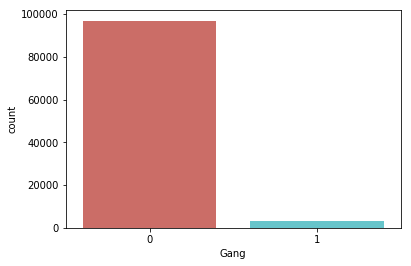

In [189]:
#Feature Reduction
#Step 1: drop all columns with 10 and 9. We only look at data within 5 years
for i in df.columns:
    if '10' in i or '9' in i:
        df = df.drop(i,axis = 1)
        
#Step 2: drop features based on domain knowledge
df = df.drop(['CareerLength','MajorGroupDetail','CvtTypes'],axis = 1)

#Step 3: drop features by plotting
sns.countplot(x='Gang',data = df,palette='hls')
plt.show()

In [190]:
#"Gang" variable has a very big variance, so we drop it
df = df.drop('Gang',axis = 1)

In [191]:
#some cleaning
df['race'] = df['race'].apply(lambda x: 'Unknown' if x == 'Unsure' else x)

In [192]:
#check missing value
df.isnull().sum()

gender                   0
race                     4
category               191
AgeAtFirst           47661
OrderProtect             0
Housing                  0
Age                    147
MisdConviction           0
FelonyConviction         0
ViolentConviction        0
ViolentOffense           0
BWO24                    0
BWO24Plus                0
Arrests                  0
FelArrests               0
MisdArrests              0
ViolArrests              0
Arrests5                 0
FelArrests5              0
MisdArrests5             0
ViolArrests5             0
Cvts                     0
FelCvts                  0
MisdCvts                 0
ViolCvts                 0
DrugCvts                 0
DrugFelCvts              0
SexCvts                  0
BurgFelCvts              0
RobFelCvts               0
LarcFelCvts              0
AssFelCvts               0
WeapFelCvts              0
Cvts5                    0
CvtCounties              0
FelCvts5                 0
MisdCvts5                0
V

In [193]:
#Fill missing values 
df['category'] = df['category'].fillna('Unspecified')
#Two main cols with missing values are AgeAtFirst and CvtDensity. Based on the data source, we replace the NA with appropriate value
df.AgeAtFirst = df.AgeAtFirst.combine_first(df.Age)
df.CvtDensity = df.CvtDensity.replace(np.nan,0)

#drop na values and check missing values again
df = df.dropna()

In [194]:
#Step 4: get dummy variables to multi-class features and make binary class features to (1,0)
cols_to_transform = ['race', 'category']
df = pd.get_dummies(df,columns = cols_to_transform) 
df['gender'] = df['gender'].apply(lambda x:1 if x == 'F' else 0)

#Step 5: make some change to specific columns
#switch 1,0 for housing col 
df['Housing'] = df['Housing'].apply(lambda x: 1  if x==0 else 0)

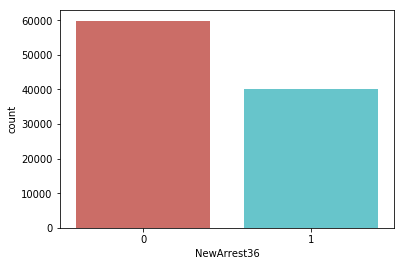

In [195]:
#check class balance 
sns.countplot(x='NewArrest36',data = df,palette='hls')
plt.show()

We ended up with 49 features:<br/>
Binary Class: Gender,Housing,MisdConviction,FelonyConviction,ViolentConviction,ViolentOffense <br/>
Multi-Class: Race, Category <br/>
and other numeric features<br/>

In [340]:
#Step 5: Split Training and Testing data
df = df.reset_index().drop('index',axis=1)
train_df = df.sample(frac=0.7, replace=False)
test_df = df[~df.index.isin(train_df.index)]

In [341]:
#check if train_df and test_df overlap
len(train_df) + len(test_df) == len(df)

True

<h3>Part 2: Feature Selection<h3/><br/>


In [162]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
%matplotlib inline

In [342]:
#Declare target variable, training data and testing data
target = 'NewArrest36'
train = train_df
test = test_df

In [164]:

def AUCCal(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)
        
    return roc_auc    


In [165]:
feature_auc_dict = {}
for col in train.drop(target,1).columns:
    feature_auc_dict[col] = AUCCal(train[col], train[target] , col)
    
df_auc = pd.DataFrame(pd.Series(feature_auc_dict), columns = ['auc'])
df_auc['auc_approx'] = df_auc['auc'].round(3)

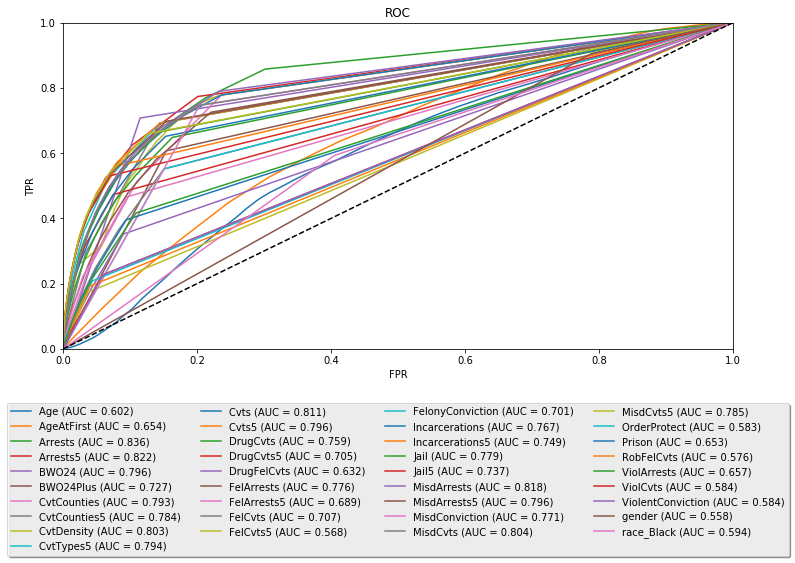

In [166]:
#with the thredshold = 0.5, we first take features with auc > 0.55
featureset_1 = list(df_auc[(df_auc.auc_approx > 0.55)].index.values)

fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#create a plot and set some options
for col in featureset_1:
    fpr, tpr, thresholds = roc_curve(train[target], train[col])
    roc_auc = auc(fpr, tpr)
    
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(train[target], -1 * train[col])
        roc_auc = auc(fpr, tpr)
        
    plt.plot(fpr, tpr, label = col + ' (AUC = %0.3f)' % roc_auc)
    

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

<h3>Part 3: Building First Models<h3/>

In [343]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score


#Set up X Y
X_train = train.drop(target, 1)
Y_train = train[target]
X_test = test.drop(target, 1)
Y_test = test[target]

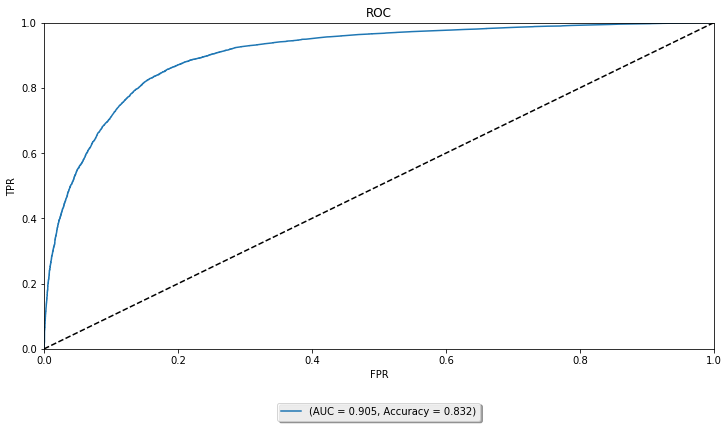

In [381]:
X_train_1 = train[featureset_1]
X_test_1 = test[featureset_1]

#Model1:Logistic Regression
logreg1 = LogisticRegression()
logreg1.fit(X_train_1,Y_train)
preds_logreg1 = logreg1.predict_proba(X_test_1)[:, 1]

#Plot
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

fpr1, tpr1, thresholds1 = roc_curve(Y_test,preds_logreg1)
roc_auc1 = roc_auc_score(Y_test,preds_logreg1)
accuracy1 = logreg1.score(X_test_1, Y_test)

plt.plot(fpr, tpr, label = '(AUC = %0.3f, Accuracy = %0.3f)' % (roc_auc1,accuracy1))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})


In [380]:
print(classification_report(Y_test,logreg1.predict(X_test_1)))

             precision    recall  f1-score   support

          0       0.84      0.88      0.86     17907
          1       0.81      0.76      0.78     12049

avg / total       0.83      0.83      0.83     29956



<h3>Feature Selection Method 1: NAÏVE SUBSET SELECTION </h3>
We are going to test if we use less features, how AUC and accuracy will change. 

In [93]:
#create a rank dataframe 
feat_ranks = df_auc[df_auc.auc_approx > 0.55].rank(axis = 0, ascending = False)
feature_test_step = np.arange(5,37,5)
feature_test_step = np.append(feature_test_step,37)

featuresetname = list()
featureset = list()
for i in feature_test_step:
    featuresetname.append('feature_top_'+str(i))
    featureset.append(list(feat_ranks[(feat_ranks.auc <= i)].index.values))
    
feature_dict = dict(zip(featuresetname,featureset))

In [111]:
def FeatureCompare(featureset,featuresetname):
    X_train_2 = train[featureset]
    X_test_2 = test[featureset]

    #Model1:Logistic Regression
    logreg = LogisticRegression()
    logreg.fit(X_train_2,Y_train)
    preds_logreg = logreg.predict_proba(X_test_2)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(Y_test,preds_logreg)
    roc_auc = roc_auc_score(Y_test,preds_logreg)
    accuracy = logreg.score(X_test_2, Y_test)
    
    plt.plot(fpr, tpr, label = featuresetname + '(AUC = %0.3f,Accuracy=%0.3f)' % (roc_auc,accuracy))
    
    return roc_auc,accuracy

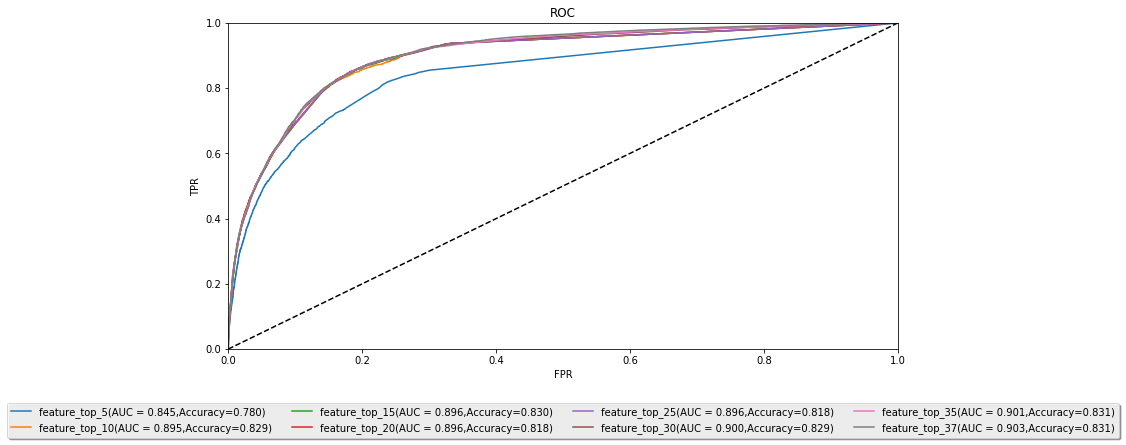

In [112]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

for key in feature_dict.keys():
    auc,accuracy = FeatureCompare(feature_dict[key],key)

    

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

<h3>Feature Selection Method 2:FORWARD STEPWISE SELECTION </h3>

In [344]:
def LR_LogLoss(cv, X_train, Y_train):
    ll = []
    
    for train_index, test_index in cv.split(X_train):
        X_train_f = X_train.iloc[train_index]
        X_vali_f = X_train.iloc[test_index]
        Y_train_f = Y_train.iloc[train_index]
        Y_vali_f = Y_train.iloc[test_index]
        
        logreg = LogisticRegression()
        logreg.fit(X_train_f, Y_train_f)
        P = logreg.predict_proba(X_vali_f)[:,1]
        P[P == 0] = 10**-10
        P[P == 1] = 0.99
        ll.append(-1*(((Y_vali_f==1)*np.log(P)+(Y_vali_f==0)*np.log(1-P)).mean()))
        
    mu = np.array(ll).mean()
    serr = np.array(ll).std()/np.sqrt(len(ll))
    
    return mu,serr

def LR_Forward_Loss(X_train,Y_train,cv):
    Curr_Best_Subset = set([])
    results = {}
    FeatureList = set(X_train.columns)
    k = 1
    
    while (len(FeatureList)>0):
        best_mu = 10**10
        best_serr = 10**10
        
        for f in FeatureList:
            feature_to_use = list(Curr_Best_Subset)+[f]
            mu,serr = LR_LogLoss(cv, X_train[feature_to_use], Y_train)
            if ((mu + serr) < (best_mu + best_serr)):
                best_mu = mu
                best_serr = serr
                best_f = f
                
                
        Curr_Best_Subset.add(best_f) #Add the best feature to the curr_best_set
        FeatureList = FeatureList.difference(Curr_Best_Subset) #Remove the best feature from the candidate set
        results[k] = [list(Curr_Best_Subset), best_mu, best_serr]
        k+=1
    return results

In [350]:
from sklearn.model_selection import KFold
#Run the forward selection
cv = KFold(n_splits = 5)
r = LR_Forward_Loss(X_train, Y_train, cv)

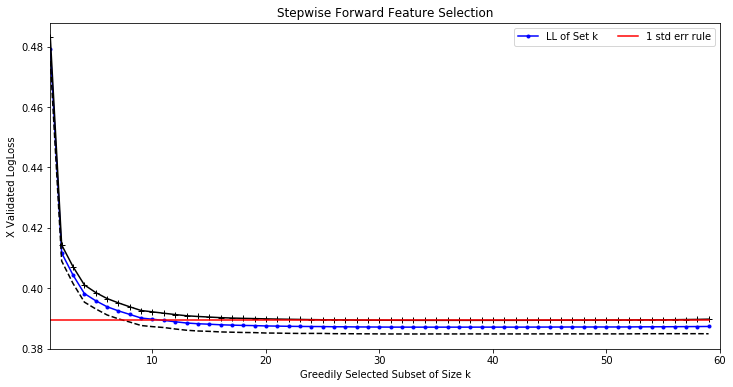

In [354]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

ks = []; mus = []; serrs = [];
for i in range(len(r.keys())):
    ks.append(i+1)
    mus.append(r[i+1][1])
    serrs.append(r[i+1][2])

    
best_1serr = min(np.array(mus) + np.array(serrs))
plt.clf()
plt.plot(ks, mus, 'b.-', label = 'LL of Set k')
plt.plot(ks, np.array(mus) + np.array(serrs), 'k+-')
plt.plot(ks, np.array(mus) - np.array(serrs), 'k--')
plt.plot(ks, np.ones(len(ks))*best_1serr, 'r', label ='1 std err rule')

plt.xlim([1,60])

plt.title('Stepwise Forward Feature Selection')
plt.xlabel('Greedily Selected Subset of Size k')
plt.ylabel('X Validated LogLoss')
    
plt.legend(loc=1, ncol=2)
plt.show()

We will choose k = 15 as the best feature sets: MisdConviction, race_White,race_Black,category_Felony,Cvts5,Housing, MisdArrests,CvtTypes5,FelCvts,AgeAtFirst,race_Asian/Pacific Islander,gender,Arrests5,CvtDensity,BWO24.

<h3> Build a second LR Model with selected 15 features </h3>

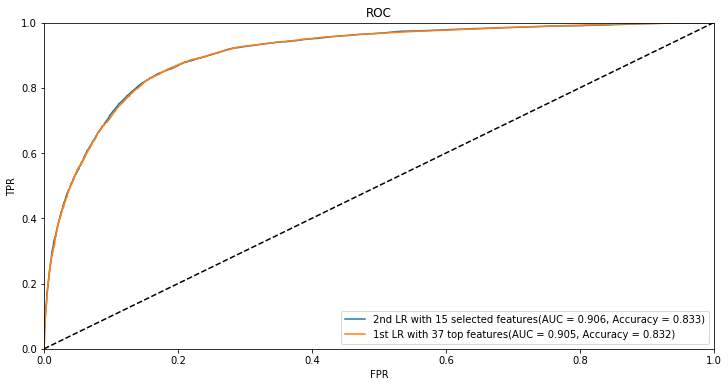

In [382]:
featureset_3 = r[15][0]
X_train_3 = train[featureset_3]
X_test_3 = test[featureset_3]

#Model1:Logistic Regression
logreg3 = LogisticRegression()
logreg3.fit(X_train_3,Y_train)
preds_logreg3 = logreg3.predict_proba(X_test_3)[:, 1]

#Plot
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

fpr3, tpr3, thresholds3 = roc_curve(Y_test,preds_logreg3)
roc_auc3 = roc_auc_score(Y_test,preds_logreg3)
accuracy3 = logreg3.score(X_test_3, Y_test)

plt.plot(fpr3, tpr3, label = '2nd LR with 15 selected features(AUC = %0.3f, Accuracy = %0.3f)' % (roc_auc3,accuracy3))
plt.plot(fpr1, tpr1, label = '1st LR with 37 top features(AUC = %0.3f, Accuracy = %0.3f)' % (roc_auc1,accuracy1))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")

In [384]:
print(classification_report(Y_test,logreg3.predict(X_test_3)))

             precision    recall  f1-score   support

          0       0.84      0.89      0.86     17907
          1       0.82      0.76      0.78     12049

avg / total       0.83      0.83      0.83     29956



From the ROC curve and Accuracy score, we could tell that by using the "Step Forward Selection" method to select features, we have a better LR model. Now we are going to test the hyperparamters in our second LR model.

<h3> Test Hyperparameters in LR </h3>

In [386]:
#From A. Muller https://github.com/amueller/mglearn/blob/master/mglearn/tools.py

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap


cm_cycle = ListedColormap(['#0000aa', '#ff5050', '#50ff50', '#9040a0', '#fff000'])
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])

# create a smooth transition from the first to to the second color of cm3
# similar to RdBu but with our red and blue, also not going through white,
# which is really bad for greyscale

cdict = {'red': [(0.0, 0.0, cm2(0)[0]),
                 (1.0, cm2(1)[0], 1.0)],

         'green': [(0.0, 0.0, cm2(0)[1]),
                   (1.0, cm2(1)[1], 1.0)],

         'blue': [(0.0, 0.0, cm2(0)[2]),
                  (1.0, cm2(1)[2], 1.0)]}

ReBl = LinearSegmentedColormap("ReBl", cdict)


def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
    Parameters
    ----------
    x1 : nd-array
        input data, first axis
    x2 : nd-array
        input data, second axis
    y : nd-array
        input data, discrete labels
    cmap : colormap
        Colormap to use.
    markers : list of string
        List of markers to use, or None (which defaults to 'o').
    s : int or float
        Size of the marker
    padding : float
        Fraction of the dataset range to use for padding the axes.
    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines



cm = cm2

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = [cm(1) if c < 0 else cm(0)
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")
    


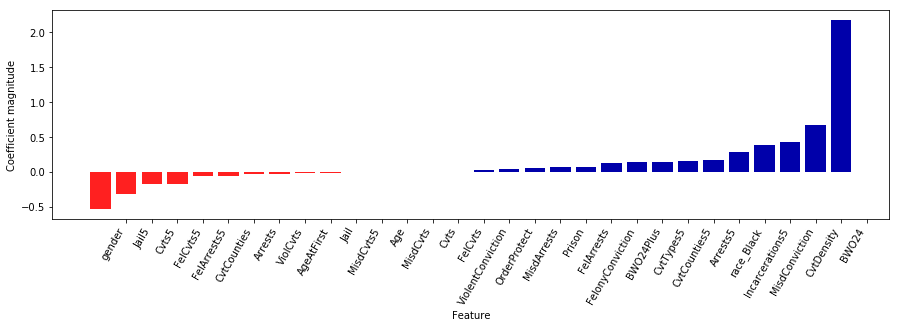

In [388]:
features=X_train_1.columns.values
visualize_coefficients(logreg1.coef_,features,n_top_features=15)

In [393]:
#From Intro to ML with Python by A Muller.
#Use Recursive Feature Elimination to find best model with n_feat
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

n_feat = 5

select = RFE(RandomForestClassifier(n_estimators=100,random_state=13),n_features_to_select=n_feat)
select.fit(X_train_1,Y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=False),
  n_features_to_select=5, step=1, verbose=0)

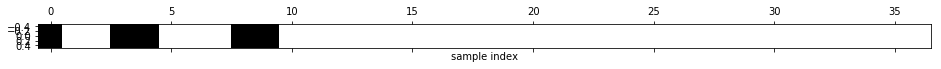

In [394]:
mask = select.get_support()
plt.matshow(mask.reshape(1,-1),cmap='gray_r')
plt.xlabel('sample index')

In [395]:
X_train_rfe = select.transform(X_train_1)
X_test_rfe = select.transform(X_test_1)

In [396]:
score = LogisticRegression().fit(X_train_rfe,Y_train).score(X_test_rfe,Y_test)
print("test score: {:.3f}".format(score))

test score: 0.828


In [139]:
print("best feature set of {:.0f} features %s".format(n_feat) % X_train_1.columns[mask]) 
#X_train_1.columns[mask]

best feature set of 5 features Index(['Arrests', 'Arrests5', 'BWO24', 'CvtDensity', 'MisdArrests'], dtype='object')


<h3>Compare LR and Random Forest</h3>

<h3> Multinomial Model </h3>

<h3> Learning Curve </h3>